# Project 4
Harshvardhan

Student Id: 609162

### Testing code for different neural network configurations
Adapted for Python 3.5.2.
Original code from Nielsen's book on Neural Network  and Deep Learning (http://neuralnetworksanddeeplearning.com/chap1.html). 

Original Author:
    Michał Dobrzański, 2016
    dobrzanski.michal.daniel@gmail.com

Modified By:
    Harshvardhan, 2021
    hello@harsh17.in


In [1]:
#### Libraries
import random
import numpy as np
import pickle
import gzip
import matplotlib.pyplot as plt

In [3]:
# %load network.py

"""
network.py
~~~~~~~~~~
IT WORKS

A module to implement the stochastic gradient descent learning
algorithm for a feedforward neural network.  Gradients are calculated
using backpropagation.  Note that I have focused on making the code
simple, easily readable, and easily modifiable.  It is not optimized,
and omits many desirable features.
"""

class Network(object):

    def __init__(self, sizes):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            test_data=None):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""

        acc = []
        
        training_data = list(training_data)
        n = len(training_data)

        if test_data:
            test_data = list(test_data)
            n_test = len(test_data)

        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                print("Epoch {} : {} / {}".format(j,self.evaluate(test_data),n_test))
                acc.append(self.evaluate(test_data)/n_test)
            else:
                print("Epoch {} complete".format(j))
        return acc

    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations-y)

#### Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

In [4]:
# %load mnist_loader.py
"""
mnist_loader
~~~~~~~~~~~~
A library to load the MNIST image data.  For details of the data
structures that are returned, see the doc strings for ``load_data``
and ``load_data_wrapper``.  In practice, ``load_data_wrapper`` is the
function usually called by our neural network code.
"""


def load_data():
    """Return the MNIST data as a tuple containing the training data,
    the validation data, and the test data.
    The ``training_data`` is returned as a tuple with two entries.
    The first entry contains the actual training images.  This is a
    numpy ndarray with 50,000 entries.  Each entry is, in turn, a
    numpy ndarray with 784 values, representing the 28 * 28 = 784
    pixels in a single MNIST image.
    The second entry in the ``training_data`` tuple is a numpy ndarray
    containing 50,000 entries.  Those entries are just the digit
    values (0...9) for the corresponding images contained in the first
    entry of the tuple.
    The ``validation_data`` and ``test_data`` are similar, except
    each contains only 10,000 images.
    This is a nice data format, but for use in neural networks it's
    helpful to modify the format of the ``training_data`` a little.
    That's done in the wrapper function ``load_data_wrapper()``, see
    below.
    """
    f = gzip.open('mnist.pkl.gz', 'rb')
    training_data, validation_data, test_data = pickle.load(f, encoding="latin1")
    f.close()
    return (training_data, validation_data, test_data)

def load_data_wrapper():
    """Return a tuple containing ``(training_data, validation_data,
    test_data)``. Based on ``load_data``, but the format is more
    convenient for use in our implementation of neural networks.
    In particular, ``training_data`` is a list containing 50,000
    2-tuples ``(x, y)``.  ``x`` is a 784-dimensional numpy.ndarray
    containing the input image.  ``y`` is a 10-dimensional
    numpy.ndarray representing the unit vector corresponding to the
    correct digit for ``x``.
    ``validation_data`` and ``test_data`` are lists containing 10,000
    2-tuples ``(x, y)``.  In each case, ``x`` is a 784-dimensional
    numpy.ndarry containing the input image, and ``y`` is the
    corresponding classification, i.e., the digit values (integers)
    corresponding to ``x``.
    Obviously, this means we're using slightly different formats for
    the training data and the validation / test data.  These formats
    turn out to be the most convenient for use in our neural network
    code."""
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = zip(training_inputs, training_results)
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = zip(validation_inputs, va_d[1])
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = zip(test_inputs, te_d[1])
    return (training_data, validation_data, test_data)

def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the jth
    position and zeroes elsewhere.  This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [5]:
# loading MNIST data
training_data, validation_data, test_data = load_data_wrapper()
training_data = list(training_data)

In [23]:
# testing the function
#input neuron, neurons in single hidden layer, output neuron
net = Network([784, 30, 10]) 

# epochs, mini_batch_size, eta
l1 = net.SGD(training_data, 30, 10, 3.0, test_data=test_data)

Epoch 0 : 9029 / 10000
Epoch 1 : 9222 / 10000
Epoch 2 : 9336 / 10000
Epoch 3 : 9361 / 10000
Epoch 4 : 9384 / 10000
Epoch 5 : 9433 / 10000
Epoch 6 : 9395 / 10000
Epoch 7 : 9405 / 10000
Epoch 8 : 9436 / 10000
Epoch 9 : 9440 / 10000
Epoch 10 : 9448 / 10000
Epoch 11 : 9454 / 10000
Epoch 12 : 9443 / 10000
Epoch 13 : 9474 / 10000
Epoch 14 : 9471 / 10000
Epoch 15 : 9474 / 10000
Epoch 16 : 9452 / 10000
Epoch 17 : 9485 / 10000
Epoch 18 : 9474 / 10000
Epoch 19 : 9481 / 10000
Epoch 20 : 9477 / 10000
Epoch 21 : 9495 / 10000
Epoch 22 : 9493 / 10000
Epoch 23 : 9482 / 10000
Epoch 24 : 9480 / 10000
Epoch 25 : 9489 / 10000
Epoch 26 : 9491 / 10000
Epoch 27 : 9477 / 10000
Epoch 28 : 9516 / 10000
Epoch 29 : 9493 / 10000


Text(0, 0.5, 'Accuracy')

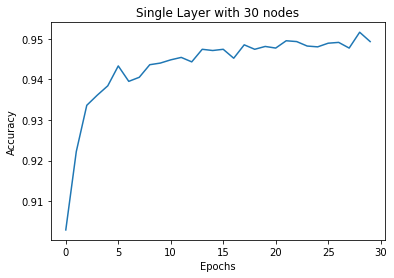

In [35]:
plt.plot(l1)
plt.title("Single Layer with 30 nodes")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

In [25]:
# loading MNIST data
training_data, validation_data, test_data = load_data_wrapper()
training_data = list(training_data)

# testing the function
#input neuron, neurons in single hidden layer, output neuron
net = Network([784, 20, 20, 10]) 

# epochs, mini_batch_size, eta
l2 = net.SGD(training_data, 30, 10, 3.0, test_data=test_data)

Epoch 0 : 8987 / 10000
Epoch 1 : 9122 / 10000
Epoch 2 : 9196 / 10000
Epoch 3 : 9244 / 10000
Epoch 4 : 9238 / 10000
Epoch 5 : 9352 / 10000
Epoch 6 : 9341 / 10000
Epoch 7 : 9354 / 10000
Epoch 8 : 9380 / 10000
Epoch 9 : 9349 / 10000
Epoch 10 : 9387 / 10000
Epoch 11 : 9378 / 10000
Epoch 12 : 9408 / 10000
Epoch 13 : 9410 / 10000
Epoch 14 : 9400 / 10000
Epoch 15 : 9436 / 10000
Epoch 16 : 9415 / 10000
Epoch 17 : 9438 / 10000
Epoch 18 : 9410 / 10000
Epoch 19 : 9418 / 10000
Epoch 20 : 9411 / 10000
Epoch 21 : 9378 / 10000
Epoch 22 : 9450 / 10000
Epoch 23 : 9460 / 10000
Epoch 24 : 9418 / 10000
Epoch 25 : 9413 / 10000
Epoch 26 : 9394 / 10000
Epoch 27 : 9425 / 10000
Epoch 28 : 9434 / 10000
Epoch 29 : 9439 / 10000


In [26]:
# loading MNIST data
training_data, validation_data, test_data = load_data_wrapper()
training_data = list(training_data)

# testing the function
#input neuron, neurons in single hidden layer, output neuron
net = Network([784, 30, 30, 10]) 

# epochs, mini_batch_size, eta
l3 = net.SGD(training_data, 30, 10, 3.0, test_data=test_data)

Epoch 0 : 9048 / 10000
Epoch 1 : 9180 / 10000
Epoch 2 : 9317 / 10000
Epoch 3 : 9295 / 10000
Epoch 4 : 9394 / 10000
Epoch 5 : 9400 / 10000
Epoch 6 : 9406 / 10000
Epoch 7 : 9390 / 10000
Epoch 8 : 9429 / 10000
Epoch 9 : 9445 / 10000
Epoch 10 : 9456 / 10000
Epoch 11 : 9484 / 10000
Epoch 12 : 9463 / 10000
Epoch 13 : 9430 / 10000
Epoch 14 : 9493 / 10000
Epoch 15 : 9447 / 10000
Epoch 16 : 9462 / 10000
Epoch 17 : 9476 / 10000
Epoch 18 : 9502 / 10000
Epoch 19 : 9454 / 10000
Epoch 20 : 9495 / 10000
Epoch 21 : 9455 / 10000
Epoch 22 : 9501 / 10000
Epoch 23 : 9472 / 10000
Epoch 24 : 9474 / 10000
Epoch 25 : 9496 / 10000
Epoch 26 : 9511 / 10000
Epoch 27 : 9524 / 10000
Epoch 28 : 9522 / 10000
Epoch 29 : 9515 / 10000


In [28]:
# loading MNIST data
training_data, validation_data, test_data = load_data_wrapper()
training_data = list(training_data)

# testing the function
#input neuron, neurons in single hidden layer, output neuron
net = Network([784, 10, 30, 10]) 

# epochs, mini_batch_size, eta
l4 = net.SGD(training_data, 30, 10, 3.0, test_data=test_data)

Epoch 0 : 8621 / 10000
Epoch 1 : 8851 / 10000
Epoch 2 : 9027 / 10000
Epoch 3 : 9107 / 10000
Epoch 4 : 9141 / 10000
Epoch 5 : 9171 / 10000
Epoch 6 : 9168 / 10000
Epoch 7 : 9116 / 10000
Epoch 8 : 9162 / 10000
Epoch 9 : 9162 / 10000
Epoch 10 : 9202 / 10000
Epoch 11 : 9199 / 10000
Epoch 12 : 9244 / 10000
Epoch 13 : 9201 / 10000
Epoch 14 : 9192 / 10000
Epoch 15 : 9223 / 10000
Epoch 16 : 9224 / 10000
Epoch 17 : 9218 / 10000
Epoch 18 : 9232 / 10000
Epoch 19 : 9244 / 10000
Epoch 20 : 9245 / 10000
Epoch 21 : 9286 / 10000
Epoch 22 : 9185 / 10000
Epoch 23 : 9256 / 10000
Epoch 24 : 9225 / 10000
Epoch 25 : 9277 / 10000
Epoch 26 : 9281 / 10000
Epoch 27 : 9283 / 10000
Epoch 28 : 9257 / 10000
Epoch 29 : 9280 / 10000


In [29]:
# loading MNIST data
training_data, validation_data, test_data = load_data_wrapper()
training_data = list(training_data)

# testing the function
#input neuron, neurons in single hidden layer, output neuron
net = Network([784, 30, 10, 10]) 

# epochs, mini_batch_size, eta
l5 = net.SGD(training_data, 30, 10, 3.0, test_data=test_data)

Epoch 0 : 9012 / 10000
Epoch 1 : 9090 / 10000
Epoch 2 : 9220 / 10000
Epoch 3 : 9253 / 10000
Epoch 4 : 9304 / 10000
Epoch 5 : 9238 / 10000
Epoch 6 : 9314 / 10000
Epoch 7 : 9364 / 10000
Epoch 8 : 9373 / 10000
Epoch 9 : 9378 / 10000
Epoch 10 : 9360 / 10000
Epoch 11 : 9376 / 10000
Epoch 12 : 9334 / 10000
Epoch 13 : 9396 / 10000
Epoch 14 : 9404 / 10000
Epoch 15 : 9424 / 10000
Epoch 16 : 9418 / 10000
Epoch 17 : 9400 / 10000
Epoch 18 : 9456 / 10000
Epoch 19 : 9386 / 10000
Epoch 20 : 9468 / 10000
Epoch 21 : 9395 / 10000
Epoch 22 : 9300 / 10000
Epoch 23 : 9456 / 10000
Epoch 24 : 9413 / 10000
Epoch 25 : 9438 / 10000
Epoch 26 : 9406 / 10000
Epoch 27 : 9435 / 10000
Epoch 28 : 9435 / 10000
Epoch 29 : 9461 / 10000


Text(0.5, 1.0, 'Convergence Paths for With Different #Layers and #Nodes')

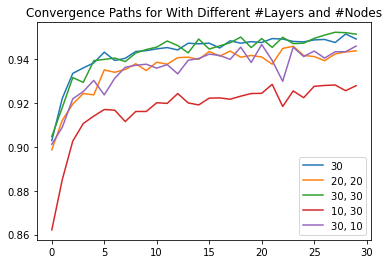

In [33]:
plt.plot(l1, label = "30")
plt.plot(l2, label = "20, 20")
plt.plot(l3, label = "30, 30")
plt.plot(l4, label = "10, 30")
plt.plot(l5, label = "30, 10")
plt.legend(loc="lower right")
plt.title("Convergence Paths for With Different #Layers and #Nodes")

In [36]:
# Task 2.2 (A)
## varying the number of epochs

# loading MNIST data
training_data, validation_data, test_data = load_data_wrapper()
training_data = list(training_data)

#input neuron, neurons in single hidden layer, output neuron
net = Network([784, 30, 10]) 

# epochs, mini_batch_size, eta
l1 = net.SGD(training_data, 10, 15, 1, test_data=test_data)

# loading MNIST data
training_data, validation_data, test_data = load_data_wrapper()
training_data = list(training_data)

#input neuron, neurons in single hidden layer, output neuron
net = Network([784, 30, 10]) 
l2 = net.SGD(training_data, 25, 15, 1, test_data=test_data)

# loading MNIST data
training_data, validation_data, test_data = load_data_wrapper()
training_data = list(training_data)

#input neuron, neurons in single hidden layer, output neuron
net = Network([784, 30, 10]) 
l3 = net.SGD(training_data, 40, 15, 1, test_data=test_data)

# loading MNIST data
training_data, validation_data, test_data = load_data_wrapper()
training_data = list(training_data)

#input neuron, neurons in single hidden layer, output neuron
net = Network([784, 30, 10]) 
l4 = net.SGD(training_data, 55, 15, 1, test_data=test_data)

# loading MNIST data
training_data, validation_data, test_data = load_data_wrapper()
training_data = list(training_data)

#input neuron, neurons in single hidden layer, output neuron
net = Network([784, 30, 10]) 
l5 = net.SGD(training_data, 70, 15, 1, test_data=test_data)

Epoch 0 : 8550 / 10000
Epoch 1 : 8905 / 10000
Epoch 2 : 9053 / 10000
Epoch 3 : 9148 / 10000
Epoch 4 : 9212 / 10000
Epoch 5 : 9253 / 10000
Epoch 6 : 9285 / 10000
Epoch 7 : 9305 / 10000
Epoch 8 : 9332 / 10000
Epoch 9 : 9344 / 10000
Epoch 0 : 8363 / 10000
Epoch 1 : 8823 / 10000
Epoch 2 : 8986 / 10000
Epoch 3 : 9082 / 10000
Epoch 4 : 9138 / 10000
Epoch 5 : 9158 / 10000
Epoch 6 : 9197 / 10000
Epoch 7 : 9204 / 10000
Epoch 8 : 9247 / 10000
Epoch 9 : 9251 / 10000
Epoch 10 : 9276 / 10000
Epoch 11 : 9271 / 10000
Epoch 12 : 9287 / 10000
Epoch 13 : 9300 / 10000
Epoch 14 : 9306 / 10000
Epoch 15 : 9341 / 10000
Epoch 16 : 9338 / 10000
Epoch 17 : 9331 / 10000
Epoch 18 : 9350 / 10000
Epoch 19 : 9349 / 10000
Epoch 20 : 9365 / 10000
Epoch 21 : 9377 / 10000
Epoch 22 : 9381 / 10000
Epoch 23 : 9375 / 10000
Epoch 24 : 9376 / 10000
Epoch 0 : 8133 / 10000
Epoch 1 : 8840 / 10000
Epoch 2 : 9055 / 10000
Epoch 3 : 9126 / 10000
Epoch 4 : 9184 / 10000
Epoch 5 : 9218 / 10000
Epoch 6 : 9248 / 10000
Epoch 7 : 9282 / 10

Text(0.5, 1.0, 'Accuracy with varying epochs, mini_batch_size = 15 and learning rate = 1')

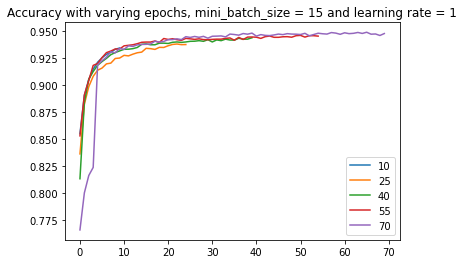

In [39]:
# Plotting
plt.plot(l1, label = "10")
plt.plot(l2, label = "25")
plt.plot(l3, label = "40")
plt.plot(l4, label = "55")
plt.plot(l5, label = "70")
plt.legend(loc="lower right")
plt.title("Accuracy with varying epochs, mini_batch_size = 15 and learning rate = 1")

In [40]:
# Task 2.2 (B)
## varying the mini batch size

# loading MNIST data
training_data, validation_data, test_data = load_data_wrapper()
training_data = list(training_data)

#input neuron, neurons in single hidden layer, output neuron
net = Network([784, 30, 10]) 

# epochs, mini_batch_size, eta
l1 = net.SGD(training_data, 20, 10, 3, test_data=test_data)

# loading MNIST data
training_data, validation_data, test_data = load_data_wrapper()
training_data = list(training_data)

#input neuron, neurons in single hidden layer, output neuron
net = Network([784, 30, 10]) 
l2 = net.SGD(training_data, 20, 15, 3, test_data=test_data)

# loading MNIST data
training_data, validation_data, test_data = load_data_wrapper()
training_data = list(training_data)

#input neuron, neurons in single hidden layer, output neuron
net = Network([784, 30, 10]) 
l3 = net.SGD(training_data, 20, 20, 3, test_data=test_data)

# loading MNIST data
training_data, validation_data, test_data = load_data_wrapper()
training_data = list(training_data)

#input neuron, neurons in single hidden layer, output neuron
net = Network([784, 30, 10]) 
l4 = net.SGD(training_data, 20, 25, 3, test_data=test_data)

# loading MNIST data
training_data, validation_data, test_data = load_data_wrapper()
training_data = list(training_data)

#input neuron, neurons in single hidden layer, output neuron
net = Network([784, 30, 10]) 
l5 = net.SGD(training_data, 20, 30, 3, test_data=test_data)

Epoch 0 : 9033 / 10000
Epoch 1 : 9221 / 10000
Epoch 2 : 9295 / 10000
Epoch 3 : 9302 / 10000
Epoch 4 : 9366 / 10000
Epoch 5 : 9330 / 10000
Epoch 6 : 9377 / 10000
Epoch 7 : 9387 / 10000
Epoch 8 : 9404 / 10000
Epoch 9 : 9414 / 10000
Epoch 10 : 9397 / 10000
Epoch 11 : 9429 / 10000
Epoch 12 : 9423 / 10000
Epoch 13 : 9420 / 10000
Epoch 14 : 9409 / 10000
Epoch 15 : 9410 / 10000
Epoch 16 : 9448 / 10000
Epoch 17 : 9448 / 10000
Epoch 18 : 9446 / 10000
Epoch 19 : 9432 / 10000
Epoch 0 : 8918 / 10000
Epoch 1 : 9073 / 10000
Epoch 2 : 9212 / 10000
Epoch 3 : 9262 / 10000
Epoch 4 : 9309 / 10000
Epoch 5 : 9309 / 10000
Epoch 6 : 9342 / 10000
Epoch 7 : 9362 / 10000
Epoch 8 : 9373 / 10000
Epoch 9 : 9386 / 10000
Epoch 10 : 9398 / 10000
Epoch 11 : 9390 / 10000
Epoch 12 : 9396 / 10000
Epoch 13 : 9416 / 10000
Epoch 14 : 9415 / 10000
Epoch 15 : 9413 / 10000
Epoch 16 : 9419 / 10000
Epoch 17 : 9433 / 10000
Epoch 18 : 9440 / 10000
Epoch 19 : 9438 / 10000
Epoch 0 : 7063 / 10000
Epoch 1 : 7957 / 10000
Epoch 2 : 8130

Text(0.5, 1.0, 'Accuracy with epochs = 20, varying mini_batch_size and learning rate = 3')

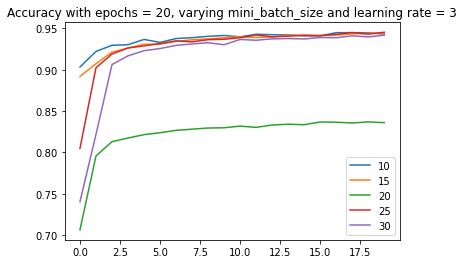

In [41]:
# Plotting
plt.plot(l1, label = "10")
plt.plot(l2, label = "15")
plt.plot(l3, label = "20")
plt.plot(l4, label = "25")
plt.plot(l5, label = "30")
plt.legend(loc = "lower right")
plt.title("Accuracy with epochs = 20, varying mini_batch_size and learning rate = 3")

In [42]:
# Task 2.2 (C)
## varying the mini batch size

# loading MNIST data
training_data, validation_data, test_data = load_data_wrapper()
training_data = list(training_data)

#input neuron, neurons in single hidden layer, output neuron
net = Network([784, 30, 10]) 

# epochs, mini_batch_size, eta
l1 = net.SGD(training_data, 20, 10, 1, test_data=test_data)

# loading MNIST data
training_data, validation_data, test_data = load_data_wrapper()
training_data = list(training_data)

#input neuron, neurons in single hidden layer, output neuron
net = Network([784, 30, 10]) 
l2 = net.SGD(training_data, 20, 10, 0.1, test_data=test_data)

# loading MNIST data
training_data, validation_data, test_data = load_data_wrapper()
training_data = list(training_data)

#input neuron, neurons in single hidden layer, output neuron
net = Network([784, 30, 10]) 
l3 = net.SGD(training_data, 20, 10, 0.01, test_data=test_data)

# loading MNIST data
training_data, validation_data, test_data = load_data_wrapper()
training_data = list(training_data)

#input neuron, neurons in single hidden layer, output neuron
net = Network([784, 30, 10]) 
l4 = net.SGD(training_data, 20, 10, 0.001, test_data=test_data)

Epoch 0 : 8818 / 10000
Epoch 1 : 9067 / 10000
Epoch 2 : 9185 / 10000
Epoch 3 : 9240 / 10000
Epoch 4 : 9265 / 10000
Epoch 5 : 9274 / 10000
Epoch 6 : 9319 / 10000
Epoch 7 : 9331 / 10000
Epoch 8 : 9351 / 10000
Epoch 9 : 9351 / 10000
Epoch 10 : 9369 / 10000
Epoch 11 : 9384 / 10000
Epoch 12 : 9373 / 10000
Epoch 13 : 9377 / 10000
Epoch 14 : 9392 / 10000
Epoch 15 : 9405 / 10000
Epoch 16 : 9406 / 10000
Epoch 17 : 9402 / 10000
Epoch 18 : 9424 / 10000
Epoch 19 : 9422 / 10000
Epoch 0 : 4028 / 10000
Epoch 1 : 5066 / 10000
Epoch 2 : 5274 / 10000
Epoch 3 : 5369 / 10000
Epoch 4 : 5497 / 10000
Epoch 5 : 5992 / 10000
Epoch 6 : 6166 / 10000
Epoch 7 : 6235 / 10000
Epoch 8 : 6298 / 10000
Epoch 9 : 6655 / 10000
Epoch 10 : 6763 / 10000
Epoch 11 : 6840 / 10000
Epoch 12 : 6881 / 10000
Epoch 13 : 6916 / 10000
Epoch 14 : 6950 / 10000
Epoch 15 : 6978 / 10000
Epoch 16 : 6992 / 10000
Epoch 17 : 7024 / 10000
Epoch 18 : 7060 / 10000
Epoch 19 : 7968 / 10000
Epoch 0 : 1549 / 10000
Epoch 1 : 1904 / 10000
Epoch 2 : 2273

Text(0.5, 1.0, 'Accuracy with epochs = 20, mini_batch_size = 10 and varying learning rate')

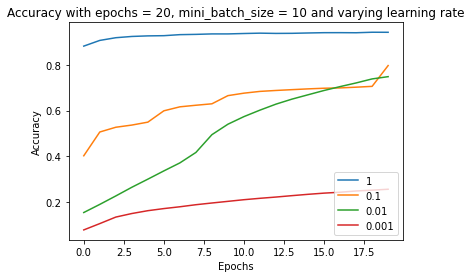

In [44]:
# Plotting
plt.plot(l1, label = "1")
plt.plot(l2, label = "0.1")
plt.plot(l3, label = "0.01")
plt.plot(l4, label = "0.001")
plt.legend(loc = "lower right")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy with epochs = 20, mini_batch_size = 10 and varying learning rate")

# XOR Gate

In [48]:
X = [(np.array([[0],[0]]), 
      np.array([[1],[0]])), 
     (np.array([[0],[1]]), 
      np.array([[0],[1]])), 
     (np.array([[1],[0]]), 
      np.array([[0],[1]])), 
     (np.array([[1],[1]]), 
      np.array([[1],[0]]))]
print(X)

[(array([[0],
       [0]]), array([[1],
       [0]])), (array([[0],
       [1]]), array([[0],
       [1]])), (array([[1],
       [0]]), array([[0],
       [1]])), (array([[1],
       [1]]), array([[1],
       [0]]))]


In [70]:
x1 = np.array([0,0])
x2 = np.array([0,1])
x3 = np.array([1,0])
x4 = np.array([1,1])

x11 = []
x22 = []
x33 = []
x44 = []

y1 = np.zeros(500)
y2 = np.ones(500)
y3 = np.ones(500)
y4 = np.zeros(500)

Y = []

for i in range(500):
    x11.append(x1 + np.random.uniform(-0.1,0.1,size = (2,)))
    x22.append(x1 + np.random.uniform(-0.1,0.1,size = (2,)))
    x33.append(x1 + np.random.uniform(-0.1,0.1,size = (2,)))
    x44.append(x1 + np.random.uniform(-0.1,0.1,size = (2,)))

X = x11 + x22 + x33 + x44
Y.append(y1[:])
Y.append(y2[:])
Y.append(y3[:])
Y.append(y4[:])

In [15]:
# testing the function
#input neuron, neurons in three hidden layers, output neuron
net = Network([2, 50, 10, 50, 2]) 

In [16]:
training_XOR = [
 (np.array([[0],[0]]), np.array([[1],[0]])), 
 (np.array([[0],[1]]), np.array([[0],[1]])),
 (np.array([[1],[0]]), np.array([[0],[1]])),
 (np.array([[1],[1]]), np.array([[1],[0]]))
]

test_XOR = [
 (np.array([[0],[0]]), 0), 
 (np.array([[0],[1]]), 1),
 (np.array([[1],[0]]), 1),
 (np.array([[1],[1]]), 0)
]

In [17]:
# epochs, mini_batch_size, eta
l = net.SGD(training_XOR, 5000, 1, 0.01, test_data=test_XOR)

Epoch 0 : 2 / 4
Epoch 1 : 2 / 4
Epoch 2 : 2 / 4
Epoch 3 : 2 / 4
Epoch 4 : 2 / 4
Epoch 5 : 2 / 4
Epoch 6 : 2 / 4
Epoch 7 : 2 / 4
Epoch 8 : 2 / 4
Epoch 9 : 2 / 4
Epoch 10 : 2 / 4
Epoch 11 : 2 / 4
Epoch 12 : 2 / 4
Epoch 13 : 2 / 4
Epoch 14 : 2 / 4
Epoch 15 : 2 / 4
Epoch 16 : 2 / 4
Epoch 17 : 2 / 4
Epoch 18 : 2 / 4
Epoch 19 : 2 / 4
Epoch 20 : 2 / 4
Epoch 21 : 2 / 4
Epoch 22 : 2 / 4
Epoch 23 : 2 / 4
Epoch 24 : 2 / 4
Epoch 25 : 2 / 4
Epoch 26 : 2 / 4
Epoch 27 : 2 / 4
Epoch 28 : 2 / 4
Epoch 29 : 2 / 4
Epoch 30 : 2 / 4
Epoch 31 : 2 / 4
Epoch 32 : 2 / 4
Epoch 33 : 2 / 4
Epoch 34 : 2 / 4
Epoch 35 : 2 / 4
Epoch 36 : 2 / 4
Epoch 37 : 2 / 4
Epoch 38 : 2 / 4
Epoch 39 : 2 / 4
Epoch 40 : 2 / 4
Epoch 41 : 2 / 4
Epoch 42 : 2 / 4
Epoch 43 : 2 / 4
Epoch 44 : 2 / 4
Epoch 45 : 2 / 4
Epoch 46 : 2 / 4
Epoch 47 : 2 / 4
Epoch 48 : 2 / 4
Epoch 49 : 2 / 4
Epoch 50 : 2 / 4
Epoch 51 : 2 / 4
Epoch 52 : 2 / 4
Epoch 53 : 2 / 4
Epoch 54 : 2 / 4
Epoch 55 : 2 / 4
Epoch 56 : 2 / 4
Epoch 57 : 2 / 4
Epoch 58 : 2 / 4
Epoch 5

Text(0.5, 1.0, 'XOR Convergence')

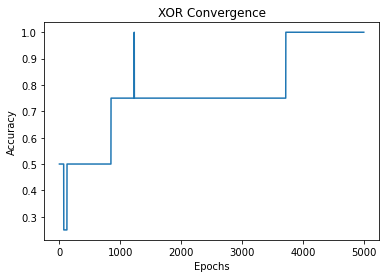

In [19]:
plt.plot(l)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("XOR Convergence")

In [24]:
# effect of network structure

training_XOR = [
 (np.array([[0],[0]]), np.array([[1],[0]])), 
 (np.array([[0],[1]]), np.array([[0],[1]])),
 (np.array([[1],[0]]), np.array([[0],[1]])),
 (np.array([[1],[1]]), np.array([[1],[0]]))
]

test_XOR = [
 (np.array([[0],[0]]), 0), 
 (np.array([[0],[1]]), 1),
 (np.array([[1],[0]]), 1),
 (np.array([[1],[1]]), 0)
]

# testing the function
net = Network([2, 50, 10, 2]) 

# epochs, mini_batch_size, eta
l1 = net.SGD(training_XOR, 5000, 1, 0.01, test_data=test_XOR)

########

Epoch 0 : 1 / 4
Epoch 1 : 1 / 4
Epoch 2 : 1 / 4
Epoch 3 : 1 / 4
Epoch 4 : 1 / 4
Epoch 5 : 1 / 4
Epoch 6 : 1 / 4
Epoch 7 : 1 / 4
Epoch 8 : 1 / 4
Epoch 9 : 1 / 4
Epoch 10 : 1 / 4
Epoch 11 : 1 / 4
Epoch 12 : 1 / 4
Epoch 13 : 1 / 4
Epoch 14 : 1 / 4
Epoch 15 : 1 / 4
Epoch 16 : 1 / 4
Epoch 17 : 1 / 4
Epoch 18 : 1 / 4
Epoch 19 : 1 / 4
Epoch 20 : 1 / 4
Epoch 21 : 1 / 4
Epoch 22 : 1 / 4
Epoch 23 : 1 / 4
Epoch 24 : 1 / 4
Epoch 25 : 1 / 4
Epoch 26 : 1 / 4
Epoch 27 : 1 / 4
Epoch 28 : 1 / 4
Epoch 29 : 1 / 4
Epoch 30 : 1 / 4
Epoch 31 : 1 / 4
Epoch 32 : 1 / 4
Epoch 33 : 1 / 4
Epoch 34 : 1 / 4
Epoch 35 : 1 / 4
Epoch 36 : 1 / 4
Epoch 37 : 1 / 4
Epoch 38 : 1 / 4
Epoch 39 : 1 / 4
Epoch 40 : 1 / 4
Epoch 41 : 1 / 4
Epoch 42 : 1 / 4
Epoch 43 : 1 / 4
Epoch 44 : 1 / 4
Epoch 45 : 1 / 4
Epoch 46 : 1 / 4
Epoch 47 : 1 / 4
Epoch 48 : 1 / 4
Epoch 49 : 2 / 4
Epoch 50 : 2 / 4
Epoch 51 : 2 / 4
Epoch 52 : 2 / 4
Epoch 53 : 2 / 4
Epoch 54 : 2 / 4
Epoch 55 : 2 / 4
Epoch 56 : 2 / 4
Epoch 57 : 2 / 4
Epoch 58 : 2 / 4
Epoch 5

In [25]:
training_XOR = [
 (np.array([[0],[0]]), np.array([[1],[0]])), 
 (np.array([[0],[1]]), np.array([[0],[1]])),
 (np.array([[1],[0]]), np.array([[0],[1]])),
 (np.array([[1],[1]]), np.array([[1],[0]]))
]

test_XOR = [
 (np.array([[0],[0]]), 0), 
 (np.array([[0],[1]]), 1),
 (np.array([[1],[0]]), 1),
 (np.array([[1],[1]]), 0)
]

# testing the function
#input neuron, neurons in single hidden layer, output neuron
net = Network([2, 10, 50, 2]) 

# epochs, mini_batch_size, eta
l2 = net.SGD(training_XOR, 5000, 10, 0.01, test_data=test_XOR)

########

training_XOR = [
 (np.array([[0],[0]]), np.array([[1],[0]])), 
 (np.array([[0],[1]]), np.array([[0],[1]])),
 (np.array([[1],[0]]), np.array([[0],[1]])),
 (np.array([[1],[1]]), np.array([[1],[0]]))
]

test_XOR = [
 (np.array([[0],[0]]), 0), 
 (np.array([[0],[1]]), 1),
 (np.array([[1],[0]]), 1),
 (np.array([[1],[1]]), 0)
]

# testing the function
#input neuron, neurons in single hidden layer, output neuron
net = Network([2, 50, 50, 2]) 

# epochs, mini_batch_size, eta
l3 = net.SGD(training_XOR, 5000, 10, 0.01, test_data=test_XOR)

########

training_XOR = [
 (np.array([[0],[0]]), np.array([[1],[0]])), 
 (np.array([[0],[1]]), np.array([[0],[1]])),
 (np.array([[1],[0]]), np.array([[0],[1]])),
 (np.array([[1],[1]]), np.array([[1],[0]]))
]

test_XOR = [
 (np.array([[0],[0]]), 0), 
 (np.array([[0],[1]]), 1),
 (np.array([[1],[0]]), 1),
 (np.array([[1],[1]]), 0)
]

# testing the function
#input neuron, neurons in single hidden layer, output neuron
net = Network([2, 10, 10, 2]) 

# epochs, mini_batch_size, eta
l4 = net.SGD(training_XOR, 5000, 10, 0.01, test_data=test_XOR)

########

training_XOR = [
 (np.array([[0],[0]]), np.array([[1],[0]])), 
 (np.array([[0],[1]]), np.array([[0],[1]])),
 (np.array([[1],[0]]), np.array([[0],[1]])),
 (np.array([[1],[1]]), np.array([[1],[0]]))
]

test_XOR = [
 (np.array([[0],[0]]), 0), 
 (np.array([[0],[1]]), 1),
 (np.array([[1],[0]]), 1),
 (np.array([[1],[1]]), 0)
]

# testing the function
#input neuron, neurons in single hidden layer, output neuron
net = Network([2, 50, 10, 50, 2]) 

# epochs, mini_batch_size, eta
l5 = net.SGD(training_XOR, 5000, 10, 0.01, test_data=test_XOR)

Epoch 0 : 2 / 4
Epoch 1 : 2 / 4
Epoch 2 : 2 / 4
Epoch 3 : 2 / 4
Epoch 4 : 2 / 4
Epoch 5 : 2 / 4
Epoch 6 : 2 / 4
Epoch 7 : 2 / 4
Epoch 8 : 2 / 4
Epoch 9 : 2 / 4
Epoch 10 : 2 / 4
Epoch 11 : 2 / 4
Epoch 12 : 2 / 4
Epoch 13 : 2 / 4
Epoch 14 : 2 / 4
Epoch 15 : 2 / 4
Epoch 16 : 2 / 4
Epoch 17 : 2 / 4
Epoch 18 : 2 / 4
Epoch 19 : 2 / 4
Epoch 20 : 2 / 4
Epoch 21 : 2 / 4
Epoch 22 : 2 / 4
Epoch 23 : 2 / 4
Epoch 24 : 2 / 4
Epoch 25 : 2 / 4
Epoch 26 : 2 / 4
Epoch 27 : 2 / 4
Epoch 28 : 2 / 4
Epoch 29 : 2 / 4
Epoch 30 : 2 / 4
Epoch 31 : 2 / 4
Epoch 32 : 2 / 4
Epoch 33 : 2 / 4
Epoch 34 : 2 / 4
Epoch 35 : 2 / 4
Epoch 36 : 2 / 4
Epoch 37 : 2 / 4
Epoch 38 : 2 / 4
Epoch 39 : 2 / 4
Epoch 40 : 2 / 4
Epoch 41 : 2 / 4
Epoch 42 : 2 / 4
Epoch 43 : 2 / 4
Epoch 44 : 2 / 4
Epoch 45 : 2 / 4
Epoch 46 : 2 / 4
Epoch 47 : 2 / 4
Epoch 48 : 2 / 4
Epoch 49 : 2 / 4
Epoch 50 : 2 / 4
Epoch 51 : 2 / 4
Epoch 52 : 2 / 4
Epoch 53 : 2 / 4
Epoch 54 : 2 / 4
Epoch 55 : 2 / 4
Epoch 56 : 2 / 4
Epoch 57 : 2 / 4
Epoch 58 : 2 / 4
Epoch 5

Text(0.5, 1.0, 'Effect of Network Structure')

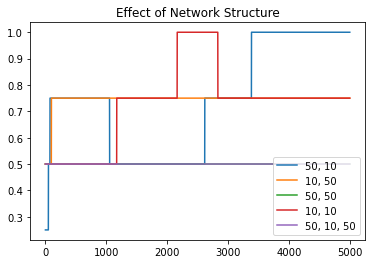

In [27]:
plt.plot(l1, label = "50, 10")
plt.plot(l2, label = "10, 50")
plt.plot(l3, label = "50, 50")
plt.plot(l4, label = "10, 10")
plt.plot(l5, label = "50, 10, 50")
plt.legend(loc="lower right")
plt.title("Effect of Network Structure")

In [28]:
# effect of learning rate

########

training_XOR = [
 (np.array([[0],[0]]), np.array([[1],[0]])), 
 (np.array([[0],[1]]), np.array([[0],[1]])),
 (np.array([[1],[0]]), np.array([[0],[1]])),
 (np.array([[1],[1]]), np.array([[1],[0]]))
]

test_XOR = [
 (np.array([[0],[0]]), 0), 
 (np.array([[0],[1]]), 1),
 (np.array([[1],[0]]), 1),
 (np.array([[1],[1]]), 0)
]

# epochs, mini_batch_size, eta
l1 = net.SGD(training_XOR, 5000, 1, 1, test_data=test_XOR)

########

training_XOR = [
 (np.array([[0],[0]]), np.array([[1],[0]])), 
 (np.array([[0],[1]]), np.array([[0],[1]])),
 (np.array([[1],[0]]), np.array([[0],[1]])),
 (np.array([[1],[1]]), np.array([[1],[0]]))
]

test_XOR = [
 (np.array([[0],[0]]), 0), 
 (np.array([[0],[1]]), 1),
 (np.array([[1],[0]]), 1),
 (np.array([[1],[1]]), 0)
]

# epochs, mini_batch_size, eta
l2 = net.SGD(training_XOR, 5000, 1, 0.1, test_data=test_XOR)

########

training_XOR = [
 (np.array([[0],[0]]), np.array([[1],[0]])), 
 (np.array([[0],[1]]), np.array([[0],[1]])),
 (np.array([[1],[0]]), np.array([[0],[1]])),
 (np.array([[1],[1]]), np.array([[1],[0]]))
]

test_XOR = [
 (np.array([[0],[0]]), 0), 
 (np.array([[0],[1]]), 1),
 (np.array([[1],[0]]), 1),
 (np.array([[1],[1]]), 0)
]

# epochs, mini_batch_size, eta
l3 = net.SGD(training_XOR, 5000, 1, 0.01, test_data=test_XOR)

########

training_XOR = [
 (np.array([[0],[0]]), np.array([[1],[0]])), 
 (np.array([[0],[1]]), np.array([[0],[1]])),
 (np.array([[1],[0]]), np.array([[0],[1]])),
 (np.array([[1],[1]]), np.array([[1],[0]]))
]

test_XOR = [
 (np.array([[0],[0]]), 0), 
 (np.array([[0],[1]]), 1),
 (np.array([[1],[0]]), 1),
 (np.array([[1],[1]]), 0)
]

# epochs, mini_batch_size, eta
l4 = net.SGD(training_XOR, 5000, 1, 0.001, test_data=test_XOR)

Epoch 0 : 2 / 4
Epoch 1 : 2 / 4
Epoch 2 : 2 / 4
Epoch 3 : 2 / 4
Epoch 4 : 2 / 4
Epoch 5 : 2 / 4
Epoch 6 : 2 / 4
Epoch 7 : 2 / 4
Epoch 8 : 2 / 4
Epoch 9 : 2 / 4
Epoch 10 : 2 / 4
Epoch 11 : 2 / 4
Epoch 12 : 2 / 4
Epoch 13 : 2 / 4
Epoch 14 : 2 / 4
Epoch 15 : 3 / 4
Epoch 16 : 2 / 4
Epoch 17 : 2 / 4
Epoch 18 : 2 / 4
Epoch 19 : 3 / 4
Epoch 20 : 2 / 4
Epoch 21 : 2 / 4
Epoch 22 : 2 / 4
Epoch 23 : 2 / 4
Epoch 24 : 3 / 4
Epoch 25 : 2 / 4
Epoch 26 : 2 / 4
Epoch 27 : 2 / 4
Epoch 28 : 3 / 4
Epoch 29 : 3 / 4
Epoch 30 : 3 / 4
Epoch 31 : 3 / 4
Epoch 32 : 2 / 4
Epoch 33 : 3 / 4
Epoch 34 : 3 / 4
Epoch 35 : 3 / 4
Epoch 36 : 3 / 4
Epoch 37 : 3 / 4
Epoch 38 : 3 / 4
Epoch 39 : 3 / 4
Epoch 40 : 3 / 4
Epoch 41 : 3 / 4
Epoch 42 : 3 / 4
Epoch 43 : 3 / 4
Epoch 44 : 4 / 4
Epoch 45 : 4 / 4
Epoch 46 : 4 / 4
Epoch 47 : 2 / 4
Epoch 48 : 2 / 4
Epoch 49 : 3 / 4
Epoch 50 : 3 / 4
Epoch 51 : 4 / 4
Epoch 52 : 2 / 4
Epoch 53 : 4 / 4
Epoch 54 : 2 / 4
Epoch 55 : 3 / 4
Epoch 56 : 4 / 4
Epoch 57 : 4 / 4
Epoch 58 : 4 / 4
Epoch 5

Text(0.5, 1.0, 'Accuracy with epochs = 5000, mini_batch_size = 1 and varying learning rate')

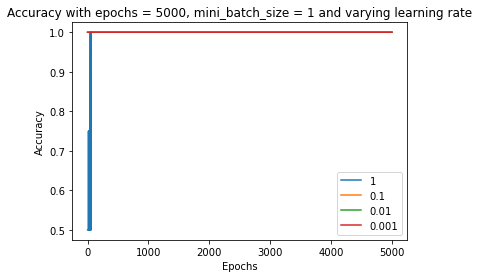

In [29]:
# Plotting
plt.plot(l1, label = "1")
plt.plot(l2, label = "0.1")
plt.plot(l3, label = "0.01")
plt.plot(l4, label = "0.001")
plt.legend(loc = "lower right")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy with epochs = 5000, mini_batch_size = 1 and varying learning rate")

In [30]:
# effect of mini batch size

########

training_XOR = [
 (np.array([[0],[0]]), np.array([[1],[0]])), 
 (np.array([[0],[1]]), np.array([[0],[1]])),
 (np.array([[1],[0]]), np.array([[0],[1]])),
 (np.array([[1],[1]]), np.array([[1],[0]]))
]

test_XOR = [
 (np.array([[0],[0]]), 0), 
 (np.array([[0],[1]]), 1),
 (np.array([[1],[0]]), 1),
 (np.array([[1],[1]]), 0)
]

# epochs, mini_batch_size, eta
l1 = net.SGD(training_XOR, 5000, 1, 0.001, test_data=test_XOR)

########

training_XOR = [
 (np.array([[0],[0]]), np.array([[1],[0]])), 
 (np.array([[0],[1]]), np.array([[0],[1]])),
 (np.array([[1],[0]]), np.array([[0],[1]])),
 (np.array([[1],[1]]), np.array([[1],[0]]))
]

test_XOR = [
 (np.array([[0],[0]]), 0), 
 (np.array([[0],[1]]), 1),
 (np.array([[1],[0]]), 1),
 (np.array([[1],[1]]), 0)
]

# epochs, mini_batch_size, eta
l2 = net.SGD(training_XOR, 5000, 10, 0.001, test_data=test_XOR)

########

training_XOR = [
 (np.array([[0],[0]]), np.array([[1],[0]])), 
 (np.array([[0],[1]]), np.array([[0],[1]])),
 (np.array([[1],[0]]), np.array([[0],[1]])),
 (np.array([[1],[1]]), np.array([[1],[0]]))
]

test_XOR = [
 (np.array([[0],[0]]), 0), 
 (np.array([[0],[1]]), 1),
 (np.array([[1],[0]]), 1),
 (np.array([[1],[1]]), 0)
]

# epochs, mini_batch_size, eta
l3 = net.SGD(training_XOR, 5000, 50, 0.001, test_data=test_XOR)

########

training_XOR = [
 (np.array([[0],[0]]), np.array([[1],[0]])), 
 (np.array([[0],[1]]), np.array([[0],[1]])),
 (np.array([[1],[0]]), np.array([[0],[1]])),
 (np.array([[1],[1]]), np.array([[1],[0]]))
]

test_XOR = [
 (np.array([[0],[0]]), 0), 
 (np.array([[0],[1]]), 1),
 (np.array([[1],[0]]), 1),
 (np.array([[1],[1]]), 0)
]

# epochs, mini_batch_size, eta
l4 = net.SGD(training_XOR, 5000, 100, 0.001, test_data=test_XOR)

Epoch 0 : 4 / 4
Epoch 1 : 4 / 4
Epoch 2 : 4 / 4
Epoch 3 : 4 / 4
Epoch 4 : 4 / 4
Epoch 5 : 4 / 4
Epoch 6 : 4 / 4
Epoch 7 : 4 / 4
Epoch 8 : 4 / 4
Epoch 9 : 4 / 4
Epoch 10 : 4 / 4
Epoch 11 : 4 / 4
Epoch 12 : 4 / 4
Epoch 13 : 4 / 4
Epoch 14 : 4 / 4
Epoch 15 : 4 / 4
Epoch 16 : 4 / 4
Epoch 17 : 4 / 4
Epoch 18 : 4 / 4
Epoch 19 : 4 / 4
Epoch 20 : 4 / 4
Epoch 21 : 4 / 4
Epoch 22 : 4 / 4
Epoch 23 : 4 / 4
Epoch 24 : 4 / 4
Epoch 25 : 4 / 4
Epoch 26 : 4 / 4
Epoch 27 : 4 / 4
Epoch 28 : 4 / 4
Epoch 29 : 4 / 4
Epoch 30 : 4 / 4
Epoch 31 : 4 / 4
Epoch 32 : 4 / 4
Epoch 33 : 4 / 4
Epoch 34 : 4 / 4
Epoch 35 : 4 / 4
Epoch 36 : 4 / 4
Epoch 37 : 4 / 4
Epoch 38 : 4 / 4
Epoch 39 : 4 / 4
Epoch 40 : 4 / 4
Epoch 41 : 4 / 4
Epoch 42 : 4 / 4
Epoch 43 : 4 / 4
Epoch 44 : 4 / 4
Epoch 45 : 4 / 4
Epoch 46 : 4 / 4
Epoch 47 : 4 / 4
Epoch 48 : 4 / 4
Epoch 49 : 4 / 4
Epoch 50 : 4 / 4
Epoch 51 : 4 / 4
Epoch 52 : 4 / 4
Epoch 53 : 4 / 4
Epoch 54 : 4 / 4
Epoch 55 : 4 / 4
Epoch 56 : 4 / 4
Epoch 57 : 4 / 4
Epoch 58 : 4 / 4
Epoch 5

Text(0.5, 1.0, 'Accuracy with epochs = 5000, varying mini_batch_size and learning rate = 0.001')

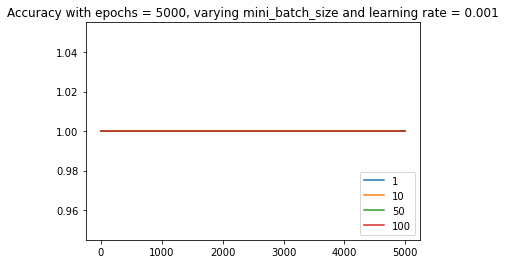

In [31]:
# Plotting
plt.plot(l1, label = "1")
plt.plot(l2, label = "10")
plt.plot(l3, label = "50")
plt.plot(l4, label = "100")
plt.legend(loc = "lower right")
plt.title("Accuracy with epochs = 5000, varying mini_batch_size and learning rate = 0.001")